## Compare trigger efficiency turn on curves using L1 weights vs HLT bit
### Assume tight ID and require high pT threshold for the lepton (15 GeV e/mu, 20 GeV tau) to match offline selections
### Would expect that at this point, we are in the plateau for the lepton filter, and inefficiency comes from cluster itself

In [59]:
import sys
import importlib
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
import awkward as ak
import dask

import ROOT
sys.path.insert(0,"../")

In [60]:
sys.path.insert(0,"../python/HNL_Plotting_HelperFunctions")
import MuonSystemReader
import HNL_Processor
import HNL_Processor_v2_e
import Processing_Helpers
import analysis_helpers


In [61]:
#load e events - dask-awkward
HNL_2GeV_10ctau_path = "root://cmseos.fnal.gov//store/group/lpclonglived/amalbert/HNL_Tau_Search/analyzer_update_111825/HNL_e_mN_2_ctau_1000/normalized/HNL_e_mN_2_ctau_1000.root"
signal_events_e  = MuonSystemReader.loadTree_nanoFactory(HNL_2GeV_10ctau_path)

/uscms/home/amalbert/.local/lib/python3.9/site-packages/coffea/nanoevents/factory.py:317: RuntimeWarning: You have set steps_per_file to 4, this should only be used for a
                small number of inputs (e.g. for early-stage/exploratory analysis) since it does not
                inform dask of each chunk lengths at creation time, which can cause unexpected
                slowdowns at scale. If you would like to process larger datasets please specify steps
                using the appropriate uproot "files" specification:
                    https://github.com/scikit-hep/uproot5/blob/v5.1.2/src/uproot/_dask.py#L109-L132.
                
  warnings.warn(
/uscms/home/amalbert/.local/lib/python3.9/site-packages/dask_awkward/lib/structure.py:911: UserWarning: Please ensure that dask.awkward<nCscRechitClusters, npartitions=4>
        is partitionwise-compatible with dask.awkward<getitem, npartitions=4>
        (e.g. counts comes from a dak.num(array, axis=1)),
        otherwise th

In [62]:
#load mu events - dask-awkward
HNL_2GeV_10ctau_path = "root://cmseos.fnal.gov//store/group/lpclonglived/amalbert/HNL_Tau_Search/analyzer_update_111825/HNL_mu_mN_2_ctau_1000/normalized/HNL_mu_mN_2_ctau_1000.root"
signal_events_mu  = MuonSystemReader.loadTree_nanoFactory(HNL_2GeV_10ctau_path)

In [63]:
#load tau events - dask-awkward
HNL_2GeV_10ctau_path = "root://cmseos.fnal.gov//store/group/lpclonglived/amalbert/HNL_Tau_Search/analyzer_update_111825/HNL_tau_mN_2_ctau_1000/normalized/HNL_tau_mN_2_ctau_1000.root"
signal_events_tau  = MuonSystemReader.loadTree_nanoFactory(HNL_2GeV_10ctau_path)

In [ ]:
def return_num_denom_HLTbit(events, lepton_type, outer_ring_only=False):
    trigger_path = {'e': 'HLT_CscCluster100_Ele5', 
                    'mu': 'HLT_CscCluster100_Mu5', 
                    'tau': 'HLT_CscCluster100_PNetTauhPFJet10_Loose'}
    if outer_ring_only:
        eta_cut=1.9
    else:
        eta_cut=10000
    events = events[events.nCscRechitClusters==1]
    denom_mask_cluster = ak.any((events.cscRechitClusterSize>=100) & 
        (events.cscRechitClusterTime>=-5) & 
        (events.cscRechitClusterTime<=12.5) & 
        (events.cscRechitClusterNRechitME1112==0) &
        (abs(events.cscRechitClusterEta)<eta_cut), axis=1)
    events = events[denom_mask_cluster]

    if lepton_type == "e":
        cluster_size = events.cscRechitClusterSize
        weights = events.pileupWeight
        denom_mask_e = ak.any((events.lepPt>=15) & (events.lepTightId) & (abs(events.lepPdgId)==11), axis=1) 
        cluster_size = cluster_size[denom_mask_e]
        weights = weights[denom_mask_e]
        trigger = events[trigger_path[lepton_type]][denom_mask_e]
    elif lepton_type == "mu":
        cluster_size = events.cscRechitClusterSize
        weights = events.pileupWeight
        denom_mask_mu = ak.any((events.lepPt>=15) & (events.lepTightId) & (abs(events.lepPdgId)==13), axis=1) 
        cluster_size = cluster_size[denom_mask_mu]
        weights = weights[denom_mask_mu]
        trigger = events[trigger_path[lepton_type]][denom_mask_mu]
    elif lepton_type == "tau":
        cluster_size = events.cscRechitClusterSize
        weights = events.pileupWeight
        denom_mask_tau = ak.any((events.tauPt>=20) & (events.tauIsTight) & (abs(events.tauEta)<2.3), axis=1) 
        cluster_size = cluster_size[denom_mask_tau]
        weights = weights[denom_mask_tau]
        trigger = events[trigger_path[lepton_type]][denom_mask_tau]
    else:
        print("lepton type not recognized")
    
    return ak.flatten(cluster_size[trigger]), ak.flatten(cluster_size), weights[trigger], weights

In [ ]:
def return_size_L1Weight(events, lepton_type, outer_ring_only=False):
    events = events[events.nCscRechitClusters==1]
    if outer_ring_only:
        eta_cut=1.9
    else:
        eta_cut=10000
    denom_mask_cluster = ak.any((events.cscRechitClusterSize>=100) & 
        (events.cscRechitClusterTime>=-5) & 
        (events.cscRechitClusterTime<=12.5) & 
        (events.cscRechitClusterNRechitME1112==0) &
        (abs(events.cscRechitClusterEta)<eta_cut), axis=1)
    events = events[denom_mask_cluster]

    if lepton_type == "e":
        cluster_size = events.cscRechitClusterSize
        weights = events.pileupWeight
        weights_L1 = ak.flatten(events.cscRechitClusterHMTEfficiency)
        denom_mask_e = ak.any((events.lepPt>=15) & (events.lepTightId) & (abs(events.lepPdgId)==11), axis=1) 
        cluster_size = cluster_size[denom_mask_e]
        weights = weights[denom_mask_e]
        weights_L1 = weights_L1[denom_mask_e]
        
    elif lepton_type == "mu":
        cluster_size = events.cscRechitClusterSize
        weights = events.pileupWeight
        weights_L1 = ak.flatten(events.cscRechitClusterHMTEfficiency)
        denom_mask_mu = ak.any((events.lepPt>=15) & (events.lepTightId) & (abs(events.lepPdgId)==13), axis=1) 
        cluster_size = cluster_size[denom_mask_mu]
        weights = weights[denom_mask_mu]
        weights_L1 = weights_L1[denom_mask_mu]
        
    elif lepton_type == "tau":
        cluster_size = events.cscRechitClusterSize
        weights = events.pileupWeight
        weights_L1 = ak.flatten(events.cscRechitClusterHMTEfficiency)
        denom_mask_tau = ak.any((events.tauPt>=20) & (events.tauIsTight) & (abs(events.tauEta)<2.3), axis=1) 
        cluster_size = cluster_size[denom_mask_tau]
        weights = weights[denom_mask_tau]
        weights_L1 = weights_L1[denom_mask_tau]
        
    else:
        print("lepton type not recognized")
    
    return ak.flatten(cluster_size), weights, weights*weights_L1

In [66]:
def make_TEfficiency_plot(num, denom, num_weight, denom_weight, bins):
    num_comp, denom_comp, num_weight, denom_weight = dask.compute(num, denom, num_weight, denom_weight)
    edges = np.ascontiguousarray(bins, dtype=np.float64)
    num_hist = ROOT.TH1F("num_hist", "numerator hist",len(bins)-1, edges)
    denom_hist = ROOT.TH1F("denom_hist", "denominator hist", len(bins)-1, edges)
    for i in range(len(num_comp)):
        num_hist.Fill(num_comp[i], num_weight[i])
    for i in range(len(denom_comp)):
        denom_hist.Fill(denom_comp[i], denom_weight[i])
    #num_hist.FillN(num_comp.size, num_comp, num_weight)
    #denom_hist.FillN(denom_comp.size, denom_comp, denom_weight)
    efficiency = ROOT.TEfficiency(num_hist, denom_hist)
    efficiency.SetStatisticOption(ROOT.TEfficiency.kFCP)
    return efficiency
    

In [67]:
def make_TEfficiency_plot_L1(size, denom_weight, num_weight, bins):
    size, denom_weight, num_weight = dask.compute(size, denom_weight, num_weight)
    edges = np.ascontiguousarray(bins, dtype=np.float64)
    num_hist = ROOT.TH1F("num_hist", "numerator hist",len(bins)-1, edges)
    denom_hist = ROOT.TH1F("denom_hist", "denominator hist", len(bins)-1, edges)
    for i in range(len(size)):
        num_hist.Fill(size[i], num_weight[i])
    for i in range(len(size)):
        denom_hist.Fill(size[i], denom_weight[i])
    #num_hist.FillN(num_comp.size, num_comp, num_weight)
    #denom_hist.FillN(denom_comp.size, denom_comp, denom_weight)
    efficiency = ROOT.TEfficiency(num_hist, denom_hist)
    efficiency.SetStatisticOption(ROOT.TEfficiency.kFCP)
    return efficiency
    

In [68]:
e_num_cluster, e_denom_cluster, e_num_weights, e_denom_weights = return_num_denom_HLTbit(signal_events_e, "e")
mu_num_cluster, mu_denom_cluster, mu_num_weights, mu_denom_weights = return_num_denom_HLTbit(signal_events_mu, "mu")
tau_num_cluster, tau_denom_cluster, tau_num_weights, tau_denom_weights = return_num_denom_HLTbit(signal_events_tau, "tau")

In [69]:
e_num_cluster_OR, e_denom_cluster_OR, e_num_weights_OR, e_denom_weights_OR = return_num_denom_HLTbit(signal_events_e, "e", outer_ring_only=True)
mu_num_cluster_OR, mu_denom_cluster_OR, mu_num_weights_OR, mu_denom_weights_OR = return_num_denom_HLTbit(signal_events_mu, "mu", outer_ring_only=True)
tau_num_cluster_OR, tau_denom_cluster_OR, tau_num_weights_OR, tau_denom_weights_OR = return_num_denom_HLTbit(signal_events_tau, "tau", outer_ring_only=True)

In [70]:
e_cluster, e_weights, e_weights_num = return_size_L1Weight(signal_events_e, "e")
mu_cluster, mu_weights, mu_weights_num = return_size_L1Weight(signal_events_mu, "mu")
tau_cluster, tau_weights, tau_weights_num = return_size_L1Weight(signal_events_tau, "tau")

In [71]:
e_cluster_OR, e_weights_OR, e_weights_num_OR = return_size_L1Weight(signal_events_e, "e", outer_ring_only=True)
mu_cluster_OR, mu_weights_OR, mu_weights_num_OR = return_size_L1Weight(signal_events_mu, "mu", outer_ring_only=True)
tau_cluster_OR, tau_weights_OR, tau_weights_num_OR = return_size_L1Weight(signal_events_tau, "tau", outer_ring_only=True)

In [72]:
bins = np.concatenate((np.arange(100, 500, 40), np.arange(500, 800+1, 100)))
bins_tau = np.concatenate((np.arange(100, 500, 80), np.arange(500, 800+1, 100)))

In [73]:

efficiency = make_TEfficiency_plot(e_num_cluster, e_denom_cluster, e_num_weights, e_denom_weights, bins = bins)
efficiency_mu = make_TEfficiency_plot(mu_num_cluster, mu_denom_cluster, mu_num_weights, mu_denom_weights, bins = bins)
efficiency_tau = make_TEfficiency_plot(tau_num_cluster, tau_denom_cluster, tau_num_weights, tau_denom_weights, bins = bins_tau)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


In [74]:

efficiency_OR = make_TEfficiency_plot(e_num_cluster_OR, e_denom_cluster_OR, e_num_weights_OR, e_denom_weights_OR, bins = bins)
efficiency_mu_OR = make_TEfficiency_plot(mu_num_cluster_OR, mu_denom_cluster_OR, mu_num_weights_OR, mu_denom_weights_OR, bins = bins)
efficiency_tau_OR = make_TEfficiency_plot(tau_num_cluster_OR, tau_denom_cluster_OR, tau_num_weights_OR, tau_denom_weights_OR, bins = bins_tau)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


In [75]:
efficiency_L1 = make_TEfficiency_plot_L1(e_cluster, e_weights, e_weights_num, bins = bins)
efficiency_mu_L1 = make_TEfficiency_plot_L1(mu_cluster, mu_weights, mu_weights_num, bins = bins)
efficiency_tau_L1 = make_TEfficiency_plot_L1(tau_cluster, tau_weights, tau_weights_num, bins = bins_tau)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


In [76]:
efficiency_L1_OR = make_TEfficiency_plot_L1(e_cluster_OR, e_weights_OR, e_weights_num_OR, bins = bins)
efficiency_mu_L1_OR = make_TEfficiency_plot_L1(mu_cluster_OR, mu_weights_OR, mu_weights_num_OR, bins = bins)
efficiency_tau_L1_OR = make_TEfficiency_plot_L1(tau_cluster_OR, tau_weights_OR, tau_weights_num_OR, bins = bins_tau)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


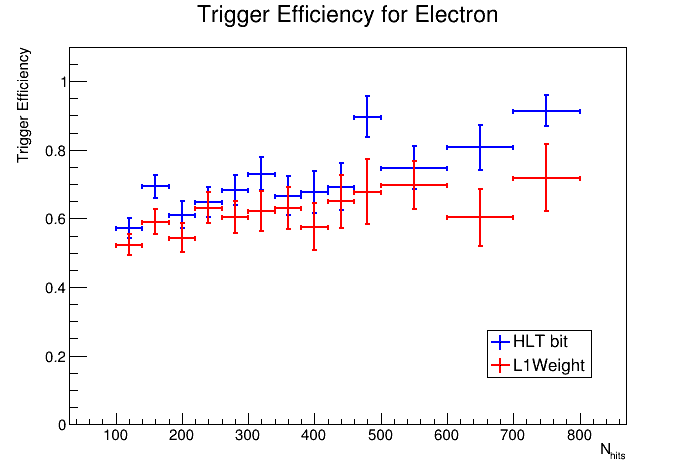

In [77]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency.SetTitle("Trigger Efficiency for Electron; N_{hits};Trigger Efficiency")
efficiency.SetLineColor(ROOT.kBlue)
efficiency.SetLineWidth(2)
efficiency.Draw()
efficiency_L1.SetLineColor(ROOT.kRed)
efficiency_L1.SetLineWidth(2)
efficiency_L1.Draw("same")

leg.AddEntry(efficiency, "HLT bit", "lep")
leg.AddEntry(efficiency_L1, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency.GetPaintedGraph().SetMinimum(0)
efficiency.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


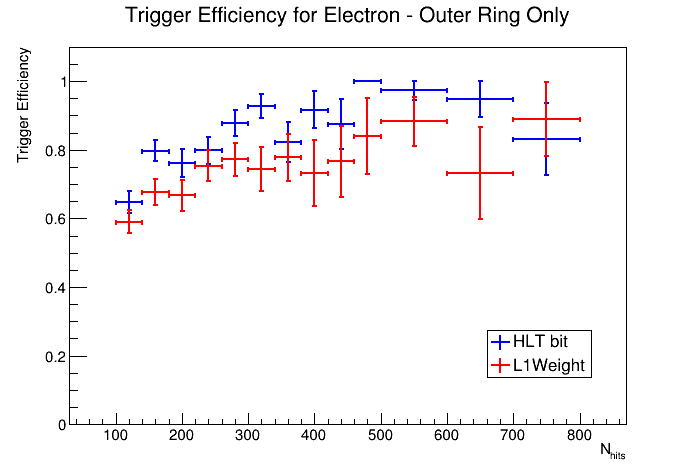

In [78]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_OR.SetTitle("Trigger Efficiency for Electron - Outer Ring Only; N_{hits};Trigger Efficiency")
efficiency_OR.SetLineColor(ROOT.kBlue)
efficiency_OR.SetLineWidth(2)
efficiency_OR.Draw()
efficiency_L1_OR.SetLineColor(ROOT.kRed)
efficiency_L1_OR.SetLineWidth(2)
efficiency_L1_OR.Draw("same")

leg.AddEntry(efficiency_OR, "HLT bit", "lep")
leg.AddEntry(efficiency_L1_OR, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_OR.GetPaintedGraph().SetMinimum(0)
efficiency_OR.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


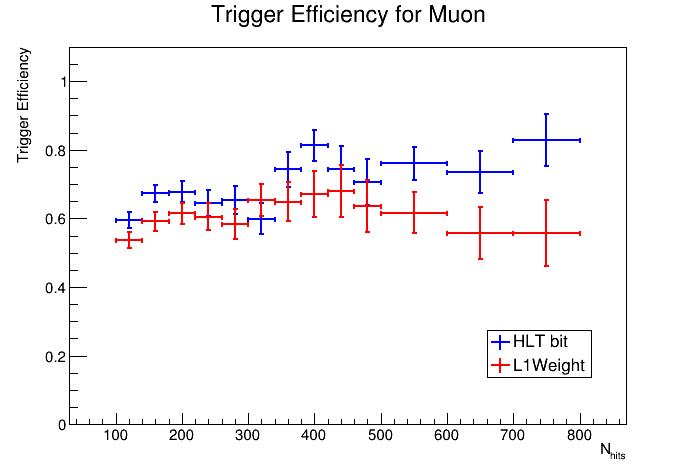

In [79]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_mu.SetTitle("Trigger Efficiency for Muon; N_{hits};Trigger Efficiency")
efficiency_mu.SetLineColor(ROOT.kBlue)
efficiency_mu.SetLineWidth(2)
efficiency_mu.Draw()
efficiency_mu_L1.SetLineColor(ROOT.kRed)
efficiency_mu_L1.SetLineWidth(2)
efficiency_mu_L1.Draw("same")

leg.AddEntry(efficiency_mu, "HLT bit", "lep")
leg.AddEntry(efficiency_mu_L1, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_mu.GetPaintedGraph().SetMinimum(0)
efficiency_mu.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


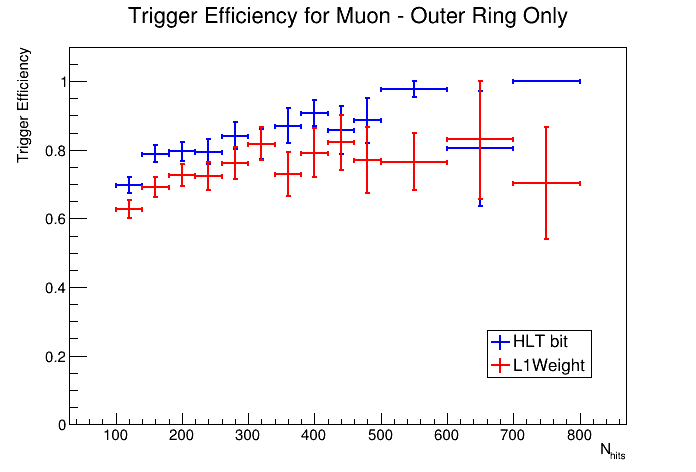

In [80]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_mu_OR.SetTitle("Trigger Efficiency for Muon - Outer Ring Only; N_{hits};Trigger Efficiency")
efficiency_mu_OR.SetLineColor(ROOT.kBlue)
efficiency_mu_OR.SetLineWidth(2)
efficiency_mu_OR.Draw()
efficiency_mu_L1_OR.SetLineColor(ROOT.kRed)
efficiency_mu_L1_OR.SetLineWidth(2)
efficiency_mu_L1_OR.Draw("same")

leg.AddEntry(efficiency_mu_OR, "HLT bit", "lep")
leg.AddEntry(efficiency_mu_L1_OR, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_mu_OR.GetPaintedGraph().SetMinimum(0)
efficiency_mu_OR.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


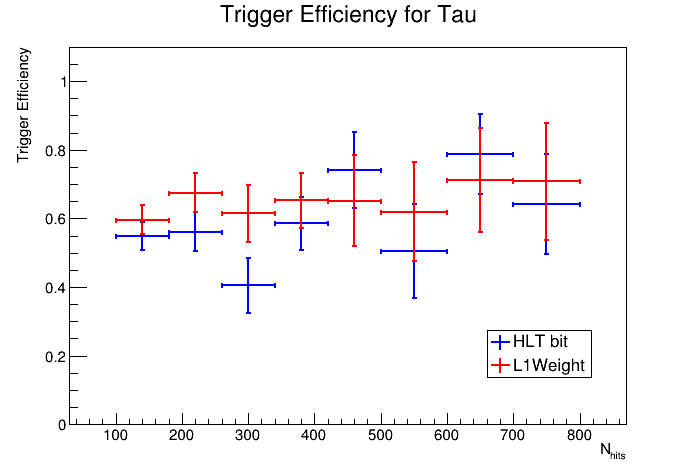

In [81]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_tau.SetTitle("Trigger Efficiency for Tau; N_{hits};Trigger Efficiency")
efficiency_tau.SetLineColor(ROOT.kBlue)
efficiency_tau.SetLineWidth(2)
efficiency_tau.Draw()
efficiency_tau_L1.SetLineColor(ROOT.kRed)
efficiency_tau_L1.SetLineWidth(2)
efficiency_tau_L1.Draw("same")
leg.AddEntry(efficiency_tau, "HLT bit", "lep")
leg.AddEntry(efficiency_tau_L1, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_tau.GetPaintedGraph().SetMinimum(0)
efficiency_tau.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


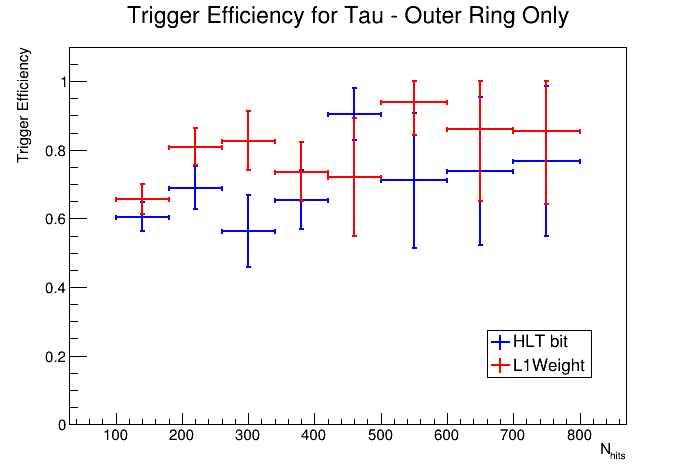

In [82]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_tau_OR.SetTitle("Trigger Efficiency for Tau - Outer Ring Only; N_{hits};Trigger Efficiency")
efficiency_tau_OR.SetLineColor(ROOT.kBlue)
efficiency_tau_OR.SetLineWidth(2)
efficiency_tau_OR.Draw()
efficiency_tau_L1_OR.SetLineColor(ROOT.kRed)
efficiency_tau_L1_OR.SetLineWidth(2)
efficiency_tau_L1_OR.Draw("same")
leg.AddEntry(efficiency_tau_OR, "HLT bit", "lep")
leg.AddEntry(efficiency_tau_L1_OR, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_tau_OR.GetPaintedGraph().SetMinimum(0)
efficiency_tau_OR.GetPaintedGraph().SetMaximum(1.1)

In [83]:
### Same comparison, but with L1 bit not HLT bit
#### Don't need cuts on lepton itself then
def return_num_denom_L1bit(events, outer_ring_only=False):
    trigger_path = 'L1_SingleMuShower_Nominal'
    events = events[events.nCscRechitClusters==1]
    if outer_ring_only:
        eta_cut=1.9
    else:
        eta_cut=10000
    denom_mask_cluster = ak.any((events.cscRechitClusterSize>=100) & 
        (events.cscRechitClusterTime>=-5) & 
        (events.cscRechitClusterTime<=12.5) & 
        (events.cscRechitClusterNRechitME1112==0) &
        (abs(events.cscRechitClusterEta)<eta_cut), axis=1)
    events = events[denom_mask_cluster]
    cluster_size = events.cscRechitClusterSize
    weights = events.pileupWeight
    trigger = events[trigger_path]
    
    return ak.flatten(cluster_size[trigger]), ak.flatten(cluster_size), weights[trigger], weights

In [84]:
def return_size_L1Weight_noLep(events, outer_ring_only=False):
    events = events[events.nCscRechitClusters==1]
    if outer_ring_only:
        eta_cut=1.9
    else:
        eta_cut=10000
    denom_mask_cluster = ak.any((events.cscRechitClusterSize>=100) & 
        (events.cscRechitClusterTime>=-5) & 
        (events.cscRechitClusterTime<=12.5) & 
        (events.cscRechitClusterNRechitME1112==0) &
        (abs(events.cscRechitClusterEta)<eta_cut), axis=1)
    events = events[denom_mask_cluster]

    cluster_size = events.cscRechitClusterSize
    weights = events.pileupWeight
    weights_L1 = ak.flatten(events.cscRechitClusterHMTEfficiency)
    cluster_size = cluster_size
    weights = weights
    weights_L1 = weights_L1
        
    return ak.flatten(cluster_size), weights, weights*weights_L1

In [99]:
e_num_cluster_L1bit, e_denom_cluster_L1bit, e_num_weights_L1bit, e_denom_weights_L1bit = return_num_denom_L1bit(signal_events_e)
mu_num_cluster_L1bit, mu_denom_cluster_L1bit, mu_num_weights_L1bit, mu_denom_weights_L1bit = return_num_denom_L1bit(signal_events_mu)
tau_num_cluster_L1bit, tau_denom_cluster_L1bit, tau_num_weights_L1bit, tau_denom_weights_L1bit = return_num_denom_L1bit(signal_events_tau)

In [100]:
e_num_cluster_L1bit_OR, e_denom_cluster_L1bit_OR, e_num_weights_L1bit_OR, e_denom_weights_L1bit_OR = return_num_denom_L1bit(signal_events_e, outer_ring_only=True)
mu_num_cluster_L1bit_OR, mu_denom_cluster_L1bit_OR, mu_num_weights_L1bit_OR, mu_denom_weights_L1bit_OR = return_num_denom_L1bit(signal_events_mu, outer_ring_only=True)
tau_num_cluster_L1bit_OR, tau_denom_cluster_L1bit_OR, tau_num_weights_L1bit_OR, tau_denom_weights_L1bit_OR = return_num_denom_L1bit(signal_events_tau, outer_ring_only=True)

In [101]:
e_cluster_noLep, e_weights_noLep, e_weights_num_noLep = return_size_L1Weight_noLep(signal_events_e)
mu_cluster_noLep, mu_weights_noLep, mu_weights_num_noLep = return_size_L1Weight_noLep(signal_events_mu)
tau_cluster_noLep, tau_weights_noLep, tau_weights_num_noLep = return_size_L1Weight_noLep(signal_events_tau)

In [102]:
e_cluster_noLep_OR, e_weights_noLep_OR, e_weights_num_noLep_OR = return_size_L1Weight_noLep(signal_events_e, outer_ring_only=True)
mu_cluster_noLep_OR, mu_weights_noLep_OR, mu_weights_num_noLep_OR = return_size_L1Weight_noLep(signal_events_mu, outer_ring_only=True)
tau_cluster_noLep_OR, tau_weights_noLep_OR, tau_weights_num_noLep_OR = return_size_L1Weight_noLep(signal_events_tau, outer_ring_only=True)

In [ ]:
efficiency_L1bit = make_TEfficiency_plot(e_num_cluster_L1bit, e_denom_cluster_L1bit, e_num_weights_L1bit, e_denom_weights_L1bit, bins = bins)
efficiency_mu_L1bit = make_TEfficiency_plot(mu_num_cluster_L1bit, mu_denom_cluster_L1bit, mu_num_weights_L1bit, mu_denom_weights_L1bit, bins = bins)
efficiency_tau_L1bit = make_TEfficiency_plot(tau_num_cluster_L1bit, tau_denom_cluster_L1bit, tau_num_weights_L1bit, tau_denom_weights_L1bit, bins = bins)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


In [104]:
efficiency_L1bit_OR = make_TEfficiency_plot(e_num_cluster_L1bit_OR, e_denom_cluster_L1bit_OR, e_num_weights_L1bit_OR, e_denom_weights_L1bit_OR, bins = bins)
efficiency_L1bit_mu_OR = make_TEfficiency_plot(mu_num_cluster_L1bit_OR, mu_denom_cluster_L1bit_OR, mu_num_weights_L1bit_OR, mu_denom_weights_L1bit_OR, bins = bins)
efficiency_L1bit_tau_OR = make_TEfficiency_plot(tau_num_cluster_L1bit_OR, tau_denom_cluster_L1bit_OR, tau_num_weights_L1bit_OR, tau_denom_weights_L1bit_OR, bins = bins)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


In [105]:
efficiency_L1_noLep = make_TEfficiency_plot_L1(e_cluster_noLep, e_weights_noLep, e_weights_num_noLep, bins = bins)
efficiency_mu_L1_noLep = make_TEfficiency_plot_L1(mu_cluster_noLep, mu_weights_noLep, mu_weights_num_noLep, bins = bins)
efficiency_tau_L1_noLep = make_TEfficiency_plot_L1(tau_cluster_noLep, tau_weights_noLep, tau_weights_num_noLep, bins = bins)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


In [106]:
efficiency_L1_noLep_OR = make_TEfficiency_plot_L1(e_cluster_noLep_OR, e_weights_noLep_OR, e_weights_num_noLep_OR, bins = bins)
efficiency_mu_L1_noLep_OR = make_TEfficiency_plot_L1(mu_cluster_noLep_OR, mu_weights_noLep_OR, mu_weights_num_noLep_OR, bins = bins)
efficiency_tau_L1_noLep_OR = make_TEfficiency_plot_L1(tau_cluster_noLep_OR, tau_weights_noLep_OR, tau_weights_num_noLep_OR, bins = bins)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


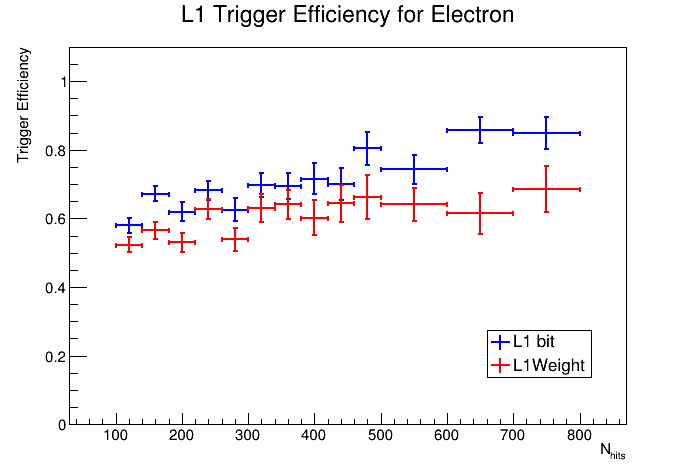

In [107]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_L1bit.SetTitle("L1 Trigger Efficiency for Electron; N_{hits};Trigger Efficiency")
efficiency_L1bit.SetLineColor(ROOT.kBlue)
efficiency_L1bit.SetLineWidth(2)
efficiency_L1bit.Draw()
efficiency_L1_noLep.SetLineColor(ROOT.kRed)
efficiency_L1_noLep.SetLineWidth(2)
efficiency_L1_noLep.Draw("same")

leg.AddEntry(efficiency_L1bit, "L1 bit", "lep")
leg.AddEntry(efficiency_L1_noLep, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_L1bit.GetPaintedGraph().SetMinimum(0)
efficiency_L1bit.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


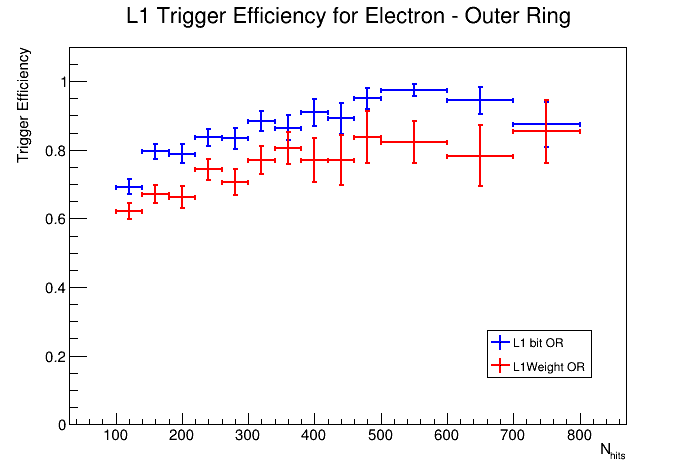

In [108]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_L1bit_OR.SetTitle("L1 Trigger Efficiency for Electron - Outer Ring; N_{hits};Trigger Efficiency")
efficiency_L1bit_OR.SetLineColor(ROOT.kBlue)
efficiency_L1bit_OR.SetLineWidth(2)
efficiency_L1bit_OR.Draw()
efficiency_L1_noLep_OR.SetLineColor(ROOT.kRed)
efficiency_L1_noLep_OR.SetLineWidth(2)
efficiency_L1_noLep_OR.Draw("same")

leg.AddEntry(efficiency_L1bit_OR, "L1 bit OR", "lep")
leg.AddEntry(efficiency_L1_noLep_OR, "L1Weight OR", "lep")
leg.Draw()
C.Draw()
efficiency_L1bit_OR.GetPaintedGraph().SetMinimum(0)
efficiency_L1bit_OR.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


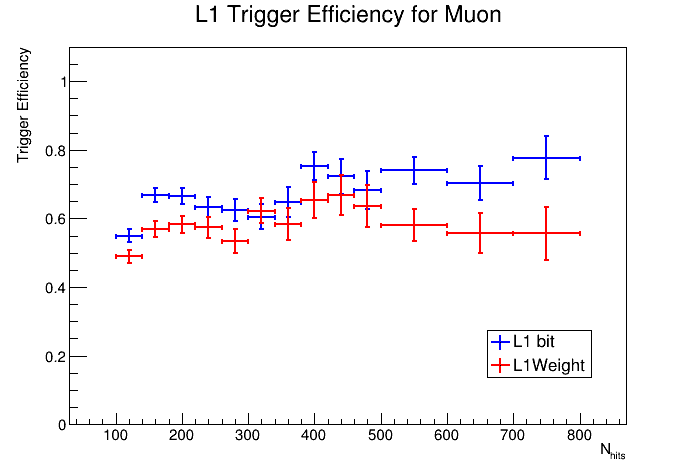

In [109]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_mu_L1bit.SetTitle("L1 Trigger Efficiency for Muon; N_{hits};Trigger Efficiency")
efficiency_mu_L1bit.SetLineColor(ROOT.kBlue)
efficiency_mu_L1bit.SetLineWidth(2)
efficiency_mu_L1bit.Draw()
efficiency_mu_L1_noLep.SetLineColor(ROOT.kRed)
efficiency_mu_L1_noLep.SetLineWidth(2)
efficiency_mu_L1_noLep.Draw("same")

leg.AddEntry(efficiency_mu_L1bit, "L1 bit", "lep")
leg.AddEntry(efficiency_mu_L1_noLep, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_mu_L1bit.GetPaintedGraph().SetMinimum(0)
efficiency_mu_L1bit.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


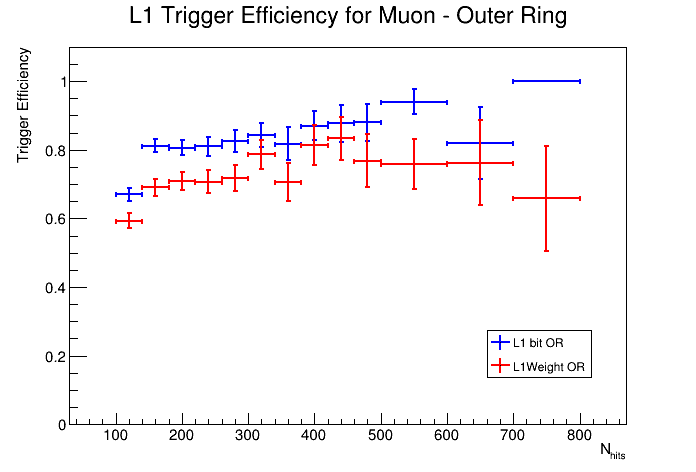

In [110]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_L1bit_mu_OR.SetTitle("L1 Trigger Efficiency for Muon - Outer Ring; N_{hits};Trigger Efficiency")
efficiency_L1bit_mu_OR.SetLineColor(ROOT.kBlue)
efficiency_L1bit_mu_OR.SetLineWidth(2)
efficiency_L1bit_mu_OR.Draw()
efficiency_mu_L1_noLep_OR.SetLineColor(ROOT.kRed)
efficiency_mu_L1_noLep_OR.SetLineWidth(2)
efficiency_mu_L1_noLep_OR.Draw("same")

leg.AddEntry(efficiency_L1bit_mu_OR, "L1 bit OR", "lep")
leg.AddEntry(efficiency_mu_L1_noLep_OR, "L1Weight OR", "lep")
leg.Draw()
C.Draw()
efficiency_L1bit_mu_OR.GetPaintedGraph().SetMinimum(0)
efficiency_L1bit_mu_OR.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


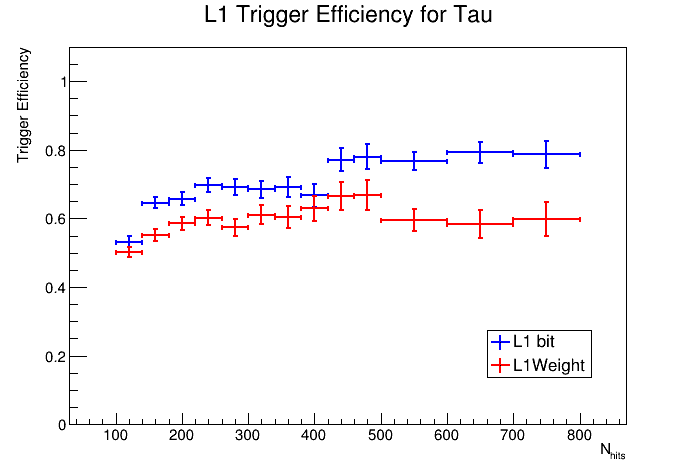

In [111]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_tau_L1bit.SetTitle("L1 Trigger Efficiency for Tau; N_{hits};Trigger Efficiency")
efficiency_tau_L1bit.SetLineColor(ROOT.kBlue)
efficiency_tau_L1bit.SetLineWidth(2)
efficiency_tau_L1bit.Draw()
efficiency_tau_L1_noLep.SetLineColor(ROOT.kRed)
efficiency_tau_L1_noLep.SetLineWidth(2)
efficiency_tau_L1_noLep.Draw("same")

leg.AddEntry(efficiency_tau_L1bit, "L1 bit", "lep")
leg.AddEntry(efficiency_tau_L1_noLep, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_tau_L1bit.GetPaintedGraph().SetMinimum(0)
efficiency_tau_L1bit.GetPaintedGraph().SetMaximum(1.1)

Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


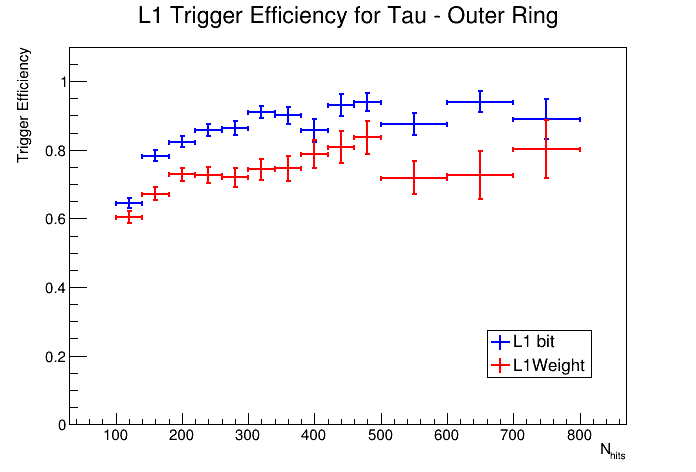

In [112]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_L1bit_tau_OR.SetTitle("L1 Trigger Efficiency for Tau - Outer Ring; N_{hits};Trigger Efficiency")
efficiency_L1bit_tau_OR.SetLineColor(ROOT.kBlue)
efficiency_L1bit_tau_OR.SetLineWidth(2)
efficiency_L1bit_tau_OR.Draw()
efficiency_tau_L1_noLep_OR.SetLineColor(ROOT.kRed)
efficiency_tau_L1_noLep_OR.SetLineWidth(2)
efficiency_tau_L1_noLep_OR.Draw("same")

leg.AddEntry(efficiency_L1bit_tau_OR, "L1 bit", "lep")
leg.AddEntry(efficiency_tau_L1_noLep_OR, "L1Weight", "lep")
leg.Draw()
C.Draw()
efficiency_L1bit_tau_OR.GetPaintedGraph().SetMinimum(0)
efficiency_L1bit_tau_OR.GetPaintedGraph().SetMaximum(1.1)

### Check HLT efficiencies with lepton requirements with L1 efficiency - proxy for HLT-specific lepton filter efficiencies

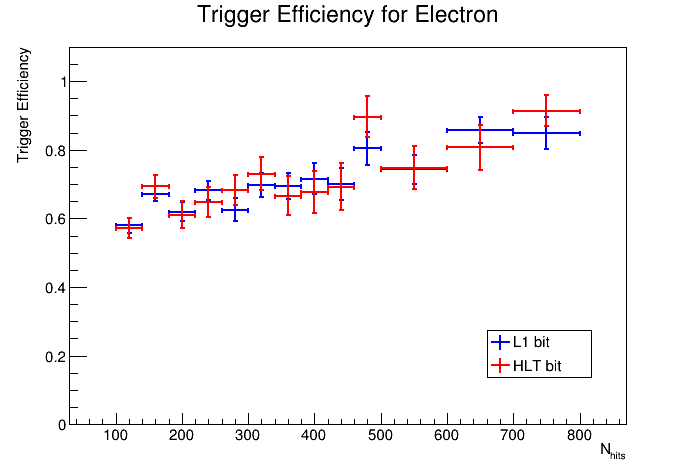

In [131]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_L1bit.SetTitle("Trigger Efficiency for Electron; N_{hits};Trigger Efficiency")
efficiency_L1bit.SetLineColor(ROOT.kBlue)
efficiency_L1bit.SetLineWidth(2)
efficiency_L1bit.Draw()
efficiency.SetLineColor(ROOT.kRed)
efficiency.SetLineWidth(2)
efficiency.Draw("same")

leg.AddEntry(efficiency_L1bit, "L1 bit", "lep")
leg.AddEntry(efficiency, "HLT bit", "lep")
leg.Draw()
C.Draw()
efficiency_L1bit.GetPaintedGraph().SetMinimum(0)
efficiency_L1bit.GetPaintedGraph().SetMaximum(1.1)

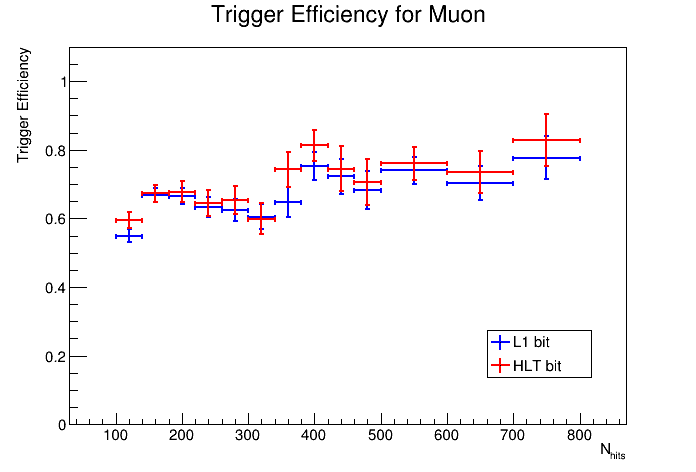

In [132]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_mu_L1bit.SetTitle("Trigger Efficiency for Muon; N_{hits};Trigger Efficiency")
efficiency_mu_L1bit.SetLineColor(ROOT.kBlue)
efficiency_mu_L1bit.SetLineWidth(2)
efficiency_mu_L1bit.Draw()
efficiency_mu.SetLineColor(ROOT.kRed)
efficiency_mu.SetLineWidth(2)
efficiency_mu.Draw("same")

leg.AddEntry(efficiency_mu_L1bit, "L1 bit", "lep")
leg.AddEntry(efficiency_mu, "HLT bit", "lep")
leg.Draw()
C.Draw()
efficiency_mu_L1bit.GetPaintedGraph().SetMinimum(0)
efficiency_mu_L1bit.GetPaintedGraph().SetMaximum(1.1)

In [133]:
efficiency_tau_L1bit_rebin = make_TEfficiency_plot(tau_num_cluster_L1bit, tau_denom_cluster_L1bit, tau_num_weights_L1bit, tau_denom_weights_L1bit, bins = bins_tau)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


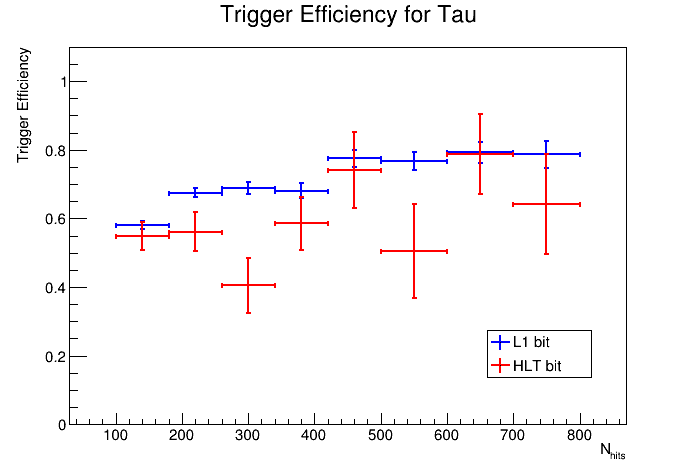

In [134]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.7,0.2,0.85,0.3)
efficiency_tau_L1bit_rebin.SetTitle("Trigger Efficiency for Tau; N_{hits};Trigger Efficiency")
efficiency_tau_L1bit_rebin.SetLineColor(ROOT.kBlue)
efficiency_tau_L1bit_rebin.SetLineWidth(2)
efficiency_tau_L1bit_rebin.Draw()
efficiency_tau.SetLineColor(ROOT.kRed)
efficiency_tau.SetLineWidth(2)
efficiency_tau.Draw("same")

leg.AddEntry(efficiency_tau_L1bit_rebin, "L1 bit", "lep")
leg.AddEntry(efficiency_tau, "HLT bit", "lep")
leg.Draw()
C.Draw()
efficiency_tau_L1bit_rebin.GetPaintedGraph().SetMinimum(0)
efficiency_tau_L1bit_rebin.GetPaintedGraph().SetMaximum(1.1)

### Estimate the efficiency of the tau part of the HLT path
#### Attempt to diagnose the clear discrepancy between the L1 and HLT efficiencies

In [154]:
#require L1 cluster bit to fire, cluster selections applied at the trigger level to pass,  and for the tau to pass DeepTau tightID and pT>20
# check HLT efficiency as a function of pT, where any inefficiency should come from HLT tau part
# taus should pass PNet VLooseID - but perhaps there is a significant difference between PNet and DeepTau?

def return_num_denom_HLTbit_givenL1(events):
    L1_path = 'L1_SingleMuShower_Nominal'
    HLT_path = 'HLT_CscCluster100_PNetTauhPFJet10_Loose'
    denom_mask_tau = ak.any((events.tauPt>=20) & (events.tauIsTight) & (abs(events.tauEta)<2.5), axis=1) 
    events = events[(events.nCscRechitClusters==1) &  (events.nTaus==1) & (events[L1_path]) & (denom_mask_tau)]
    denom_mask_cluster = ak.any((events.cscRechitClusterSize>=100) & 
        (events.cscRechitClusterTime>=-5) & 
        (events.cscRechitClusterTime<=12.5) & 
        (events.cscRechitClusterNRechitME1112==0), axis=1)
    events = events[denom_mask_cluster]
    tau_pT = ak.flatten(events.tauPt)
    weights = events.pileupWeight
    return tau_pT[events[HLT_path]], tau_pT, weights[events[HLT_path]], weights

In [155]:
num_pT, denom_pT, num_weights_pT, denom_weights_pT = return_num_denom_HLTbit_givenL1(signal_events_tau)

In [156]:
bins_pT = np.concatenate((np.arange(20, 50, 5), np.arange(50, 200+1, 10)))
efficiency_pT = make_TEfficiency_plot(num_pT, denom_pT, num_weights_pT, denom_weights_pT, bins = bins_pT)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


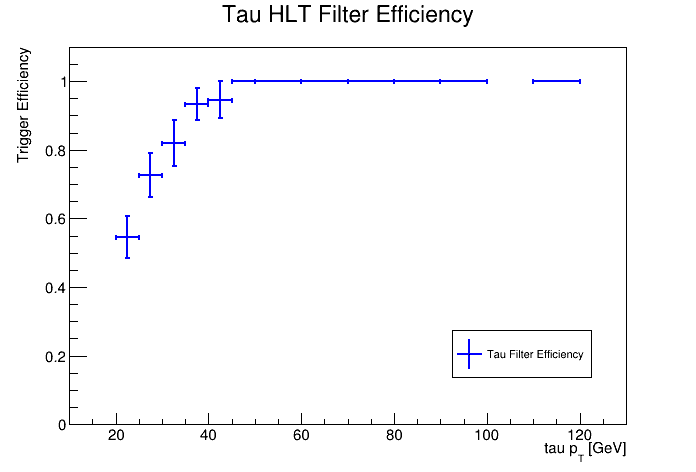

In [157]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.65,0.2,0.85,0.3)
efficiency_pT.SetTitle("Tau HLT Filter Efficiency; tau p_{T} [GeV];Trigger Efficiency")
efficiency_pT.SetLineColor(ROOT.kBlue)
efficiency_pT.SetLineWidth(2)
efficiency_pT.Draw()


leg.AddEntry(efficiency_pT, "Tau Filter Efficiency", "lep")
leg.Draw()
C.Draw()
efficiency_pT.GetPaintedGraph().SetMinimum(0)
efficiency_pT.GetPaintedGraph().SetMaximum(1.1)

### Same exercise, but with PNet Taus

In [178]:
# validate method by checking HLT efficiency with tight PNet taus
#require L1 cluster bit to fire, cluster selections applied at the trigger level to pass,  and for the tau to pass DeepTau tightID and pT>20
# check HLT efficiency as a function of pT, where any inefficiency should come from HLT tau part
# taus should pass PNet VLooseID - but perhaps there is a significant difference between PNet and DeepTau?

def return_num_denom_HLTbit_givenL1_PNet(events):
    L1_path = 'L1_SingleMuShower_Nominal'
    HLT_path = 'HLT_CscCluster100_PNetTauhPFJet10_Loose'
    denom_mask_tau = ak.any((events.tauPt>=20) & (abs(events.tauEta)<2.5), axis=1) 
    PNet_Tau_mask = ak.any((events.tauPNetVSe>0.991) & (events.tauPNetVSmu>0.956) & (events.tauPNetVSjet>0.906), axis=1)
    
    events = events[(events.nCscRechitClusters==1) &  (events.nTaus==1) & (events[L1_path]) & (denom_mask_tau) & (PNet_Tau_mask)]
    denom_mask_cluster = ak.any((events.cscRechitClusterSize>=100) & 
        (events.cscRechitClusterTime>=-5) & 
        (events.cscRechitClusterTime<=12.5) & 
        (events.cscRechitClusterNRechitME1112==0), axis=1)
    events = events[denom_mask_cluster]
    tau_pT = ak.flatten(events.tauPt)
    weights = events.pileupWeight
    return tau_pT[events[HLT_path]], tau_pT, weights[events[HLT_path]], weights

In [179]:
num_pT_PNet, denom_pT_PNet, num_weights_pT_PNet, denom_weights_pT_PNet = return_num_denom_HLTbit_givenL1_PNet(signal_events_tau)

In [180]:
efficiency_pT_PNet = make_TEfficiency_plot(num_pT_PNet, denom_pT_PNet, num_weights_pT_PNet, denom_weights_pT_PNet, bins = bins_pT)


Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


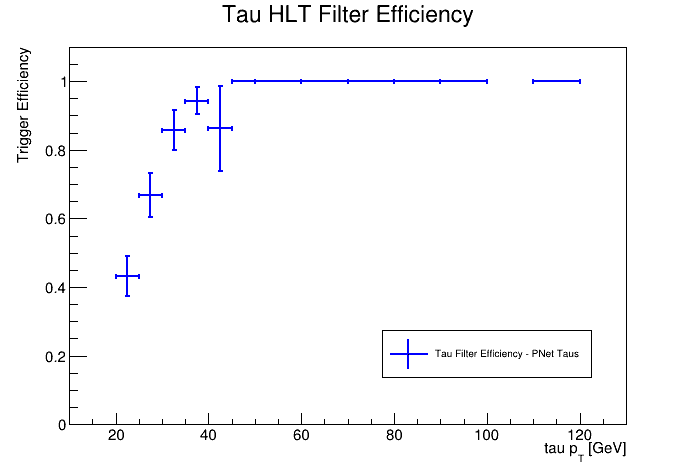

In [181]:
C = ROOT.TCanvas()
leg = ROOT.TLegend(0.55,0.2,0.85,0.3)
efficiency_pT_PNet.SetTitle("Tau HLT Filter Efficiency; tau p_{T} [GeV];Trigger Efficiency")
efficiency_pT_PNet.SetLineColor(ROOT.kBlue)
efficiency_pT_PNet.SetLineWidth(2)
efficiency_pT_PNet.Draw()


leg.AddEntry(efficiency_pT_PNet, "Tau Filter Efficiency - PNet Taus", "lep")
leg.Draw()
C.Draw()
efficiency_pT_PNet.GetPaintedGraph().SetMinimum(0)
efficiency_pT_PNet.GetPaintedGraph().SetMaximum(1.1)